In [77]:
import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import optax
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
import disrnn
import rnn_utils
from rnn_utils import DatasetRNN
import subject_data
from subject_data import SubjectData
from tueplots import bundles, figsizes, cycler
from tueplots.constants import markers
from tueplots.constants.color import rgb, palettes

plt.rcParams.update({"figure.dpi": 150})

Leave-one-out cross-validation for only one subject + plots

# Load Data

In [78]:
data_dir = '..\data\data_for_Meike.mat'
matDf = loadmat(data_dir)['data']
df = pd.DataFrame(np.squeeze(np.array(matDf.tolist())).T, columns=matDf.dtype.names).drop(columns=['label','Spcorrect1', 'Spcorrect2', 'Snoise']).sort_values(by=['subject', 'trial'])

# Define target and list of features from previous trial and current trial
features_prev = ['type', 'theta', 'Pconfidence', 'Pacc', 'Sacc', 'select', 'Reward', 'Sconfidence']
features_curr = ['type', 'theta', 'Sacc']
target = ['Sconfidence']

data = SubjectData(
        df, 
        features_prev, 
        features_curr,
        target,
        categorical_partners=True, 
        categorical_theta=True) 

features = data.features_prev + data.features_curr
subject_idx = 7
data()



,subject,block,trial,dtheta,type,Pchoice,Preport,Pacc,Schoice,Sreport,...,b2_p1_previous,b2_p2_previous,b3_p1_previous,b3_p2_previous,b4_p1_previous,b4_p2_previous,theta_1_previous,theta_2_previous,theta_3_previous,theta_4_previous
0,1.0,1.0,1.0,0.18,2.0,-1.0,5.0,0.0,1.0,3.0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,1.0,2.0,-0.11,2.0,-1.0,6.0,1.0,-1.0,4.0,...,0,0,0,0,0,0,0,0,1,0
2,1.0,1.0,3.0,-0.27,1.0,-1.0,3.0,1.0,-1.0,6.0,...,0,0,0,0,0,0,0,1,0,0
3,1.0,1.0,4.0,0.18,2.0,1.0,6.0,1.0,1.0,5.0,...,0,0,0,0,0,0,0,0,0,1
4,1.0,1.0,5.0,0.05,1.0,-1.0,3.0,0.0,1.0,1.0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7675,30.0,4.0,252.0,-0.13,2.0,1.0,3.0,0.0,-1.0,4.0,...,0,0,0,0,0,1,0,1,0,0
7676,30.0,4.0,253.0,0.13,1.0,1.0,5.0,1.0,-1.0,2.0,...,0,0,0,0,0,1,0,1,0,0
7677,30.0,4.0,254.0,0.05,2.0,-1.0,3.0,0.0,-1.0,4.0,...,0,0,0,0,1,0,0,1,0,0
7678,30.0,4.0,255.0,0.05,2.0,1.0,4.0,1.0,-1.0,3.0,...,0,0,0,0,0,1,1,0,0,0


In [79]:
data_df = data.__call__()
data_s4 = data_df[data_df['subject'] == 28]
data_s4_p1 = data_s4[data_s4['type'] == 1]
data_s4_p2 = data_s4[data_s4['type'] == 2]

# # plot choices separated by partner
# plt.figure(figsize=(10, 5))
# plt.plot(data_s4_p1['Preport'], label='Sconfidence partner 1')
# plt.plot(data_s4_p2['Preport'], label='Sconfidence partner 2')
# plt.legend()


In [80]:
print(data_s4_p1['Sconfidence'].value_counts(), data_s4_p2['Sconfidence'].value_counts())

Sconfidence
0    80
1    48
Name: count, dtype: int64 Sconfidence
1    101
0     27
Name: count, dtype: int64


In [81]:
print(data_s4_p1['Pconfidence'].value_counts(), data_s4_p2['Pconfidence'].value_counts())

Pconfidence
0    96
1    32
Name: count, dtype: int64 Pconfidence
1    96
0    32
Name: count, dtype: int64


In [82]:
data_s4['Sreport'].mean()

3.72265625

In [83]:
print(data_s4_p1['Sreport'].value_counts(), data_s4_p2['Sreport'].value_counts())

Sreport
4.0    41
3.0    41
2.0    28
5.0    12
1.0     5
6.0     1
Name: count, dtype: int64 Sreport
4.0    72
5.0    21
6.0    16
3.0    15
1.0     3
2.0     1
Name: count, dtype: int64


# Create Train and Test

@Sara: here you can switch between LOOCV and only one subject

In [84]:
#train, test = subject_data.train_test(data(), features, target, batch_size=None)
train, test = subject_data.single_subject(data(), features, target, subject_idx=subject_idx, batch_size=1)

Set up Disentangled RNN

In [85]:
n_features = len(features)
target_size = len(np.unique(df[target]))
latent_size = 10
hidden_size = int(np.ceil(np.mean([n_features, target_size])))
obs_size = n_features

# Number of hidden units in each of the two layers of the choice MLP.
update_mlp_shape = (3,3,)
# # Number of hidden units in each of the two layers of the update MLP.
choice_mlp_shape = (2,2,) 

def make_disrnn():
  model = disrnn.HkDisRNN(
      obs_size = obs_size,
      latent_size = latent_size,
      update_mlp_shape = update_mlp_shape,
      choice_mlp_shape = choice_mlp_shape,
      target_size=target_size,
      beta_scale=1)
  return model

def make_disrnn_eval():
  model = disrnn.HkDisRNN(
          obs_size = obs_size,
          latent_size = latent_size,
          update_mlp_shape = update_mlp_shape,
          choice_mlp_shape = choice_mlp_shape,
          target_size=target_size,
          eval_mode=True,
          beta_scale=1)               
  return model

optimizer = optax.adam(learning_rate=1e-2)

Fit disRNN with no penalty at first, to get good quality-of-fit

Step 2000 of 2000; Loss: 2.8047e+01. (Time: 144.0s)

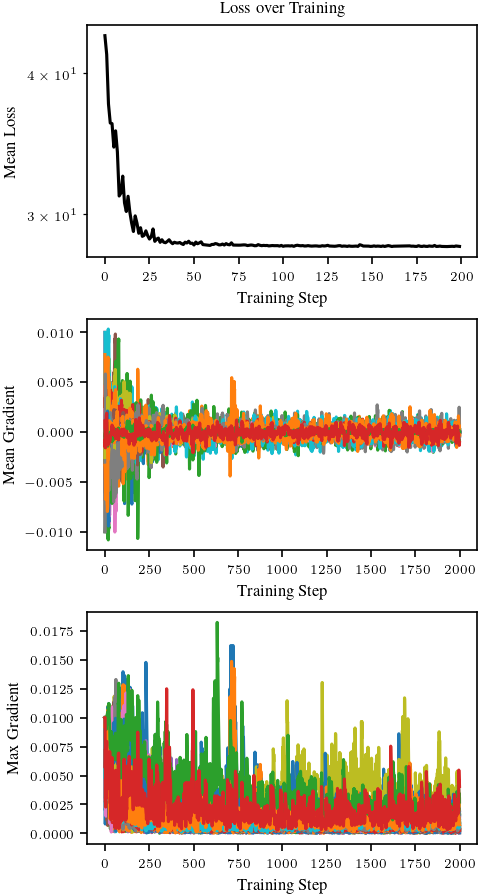

In [86]:
n_steps = 2000 #@param
information_penalty = 0

disrnn_params, opt_state, losses = rnn_utils.train_model(
    model_fun = make_disrnn,
    dataset = train,
    optimizer = optimizer,
    loss_fun = 'penalized_categorical',
    penalty_scale=information_penalty,
    n_steps=n_steps,
    do_plot=True,
    truncate_seq_length=None
)

Step 3000 of 3000; Loss: 3.2083e+01. (Time: 181.9s)

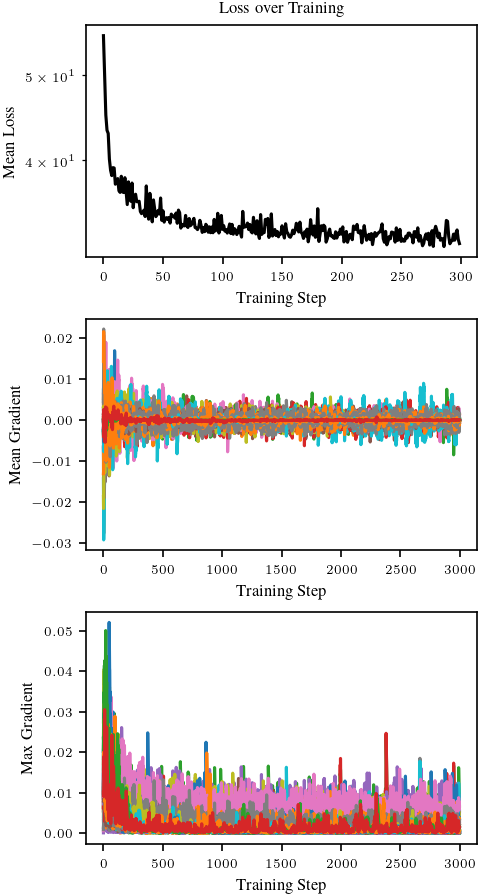

In [87]:
# Now fit more steps with a penalty, to encourage it to find a simple solution
n_steps = 3000  #@param
information_penalty = 1e-3 #@param

disrnn_params, opt_state, losses = rnn_utils.train_model(
    model_fun = make_disrnn,
    dataset = train,
    optimizer = optimizer, 
    loss_fun = 'penalized_categorical',
    params=disrnn_params,
    opt_state=opt_state,
    penalty_scale=information_penalty,
    n_steps=n_steps,
    truncate_seq_length=None,
)

Visualize model latents

In [88]:
# Visualize bottleneck latents + learned update.

#disrnn.plot_bottlenecks(disrnn_params, obs_names=features)
#disrnn.plot_update_rules(disrnn_params, make_disrnn_eval)


# Calculate Normalized likelihoods

In [89]:
print('Normalized Likelihoods for Disentangled RNN')
print('Training Dataset')
training_likelihood, training_output = subject_data.compute_log_likelihood(
    train, make_disrnn_eval, disrnn_params)
print('Held-Out Dataset')
testing_likelihood, test_output = subject_data.compute_log_likelihood(
    test, make_disrnn_eval, disrnn_params)

Normalized Likelihoods for Disentangled RNN
Training Dataset


Normalized Likelihood: 73.5%
Held-Out Dataset
Normalized Likelihood: 57.3%


## Plot the predictions for the TRAIN set

In [115]:
xs, actual_choices = train._xs, train._ys # performance for the training or test set
n_trials_per_session, n_subjects = actual_choices.shape[:2]
model_outputs, model_states = rnn_utils.eval_model(make_disrnn_eval, disrnn_params, xs)

model_outputs = jax.nn.softmax(model_outputs[:, :, :-1], axis=-1)  # Last entry is nans.

Plot the model predictions

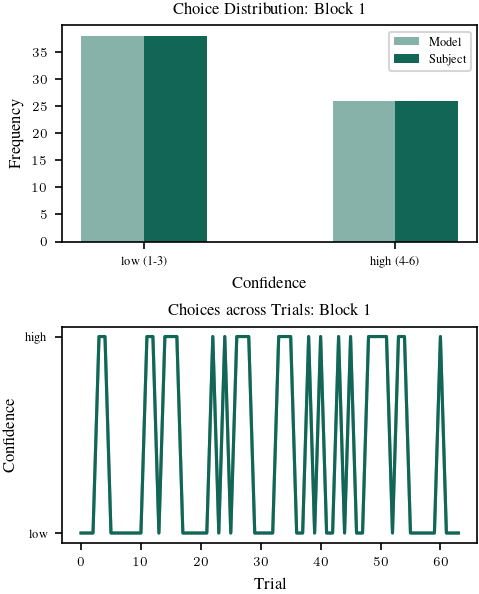

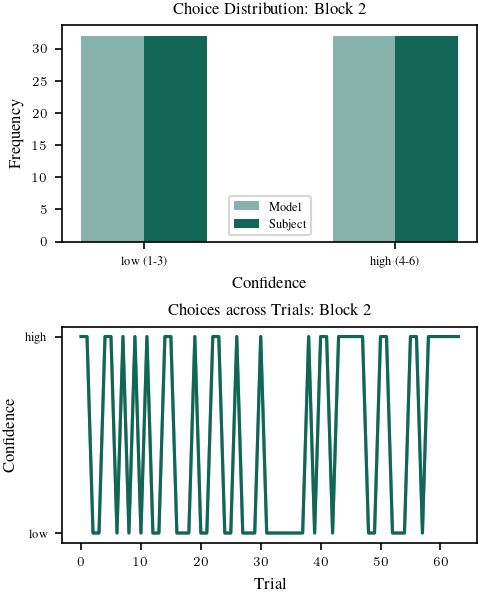

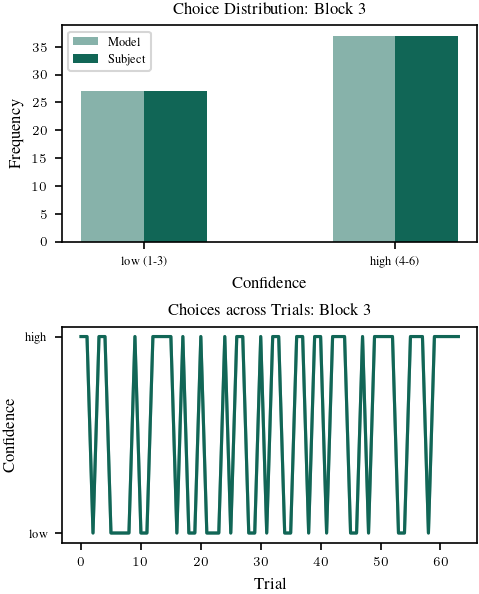

In [116]:
plt.rcParams.update(
    bundles.icml2022(
        column="full",
        nrows=1,
        ncols=2,
        usetex=True,
    )
)
plt.rcParams.update(figsizes.icml2022_half(nrows=2, ncols=1))

for i in range(model_outputs.shape[1]):

    model_choice = np.argmax(model_outputs[:, i, :], axis=-1)
    model_counts = (np.sum(model_choice == 0), np.sum(model_choice == 1))

    subject_choice = actual_choices[:, i,0]
    subject_counts = (np.sum(subject_choice == 0), np.sum(subject_choice == 1))
    
    # Plot the distribution of choices for each subject
    labels = ("low (1-3)", "high (4-6)")
    all_choices = {'Model': model_counts, 'Subject': subject_counts}
    x = np.arange(len(labels))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0


    fig, ax = plt.subplots(2, 1)
    
    for identity, count in all_choices.items():
        offset = width * multiplier
        if identity == 'Model':
            alpha = 0.5
        else:
            alpha = 1  
        rects = ax[0].bar(x + offset, count, width, alpha=alpha, color=rgb.mps_green, label=identity)
        multiplier += 1

    ax[0].set_ylabel('Frequency')
    ax[0].set_xlabel('Confidence')
    ax[0].set_title('Choice Distribution: Block {subject} '.format(subject=i+1))
    ax[0].set_xticks(x + width/2, labels)
    ax[0].legend()
    
    # Plot the choices across all trials
    ax[1].plot(model_choice, alpha=0.5, color=rgb.mps_green, label='Model')
    ax[1].plot(subject_choice, color=rgb.mps_green, label='Subject')
    
    ax[1].set_xlabel('Trial')
    ax[1].set_ylabel('Confidence')
    #ax[1].set_yticks([-1,0,1], labels=['invalid', 'low', 'high'])
    ax[1].set_yticks([0,1], labels=['low', 'high'])
    ax[1].set_title('Choices across Trials: Block {subject} '.format(subject=i+1))

    plt.show()

Plot for each partner seperately

In [117]:
# extract the model outputs for the two partners
mask_p1, mask_p2 = data.extract_trial_indices(2)
mask_p1 = mask_p1[:, :-1]==1
mask_p2 = mask_p2[:, :-1]==1

model_outputs_partner1 = model_outputs[mask_p1, :].reshape(32,3,2)
model_outputs_partner2 = model_outputs[mask_p2, :].reshape(32,3,2)

# extract the actual choices for the two partners
actual_choices_partner1 = actual_choices[mask_p1, 0].reshape(32,3)
actual_choices_partner2 = actual_choices[mask_p2, 0].reshape(32,3)

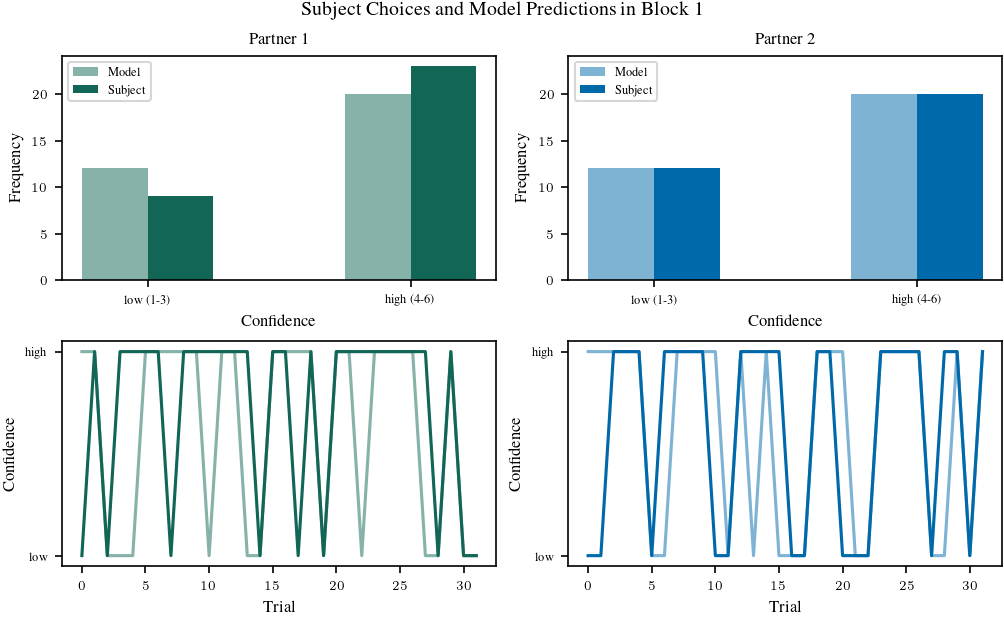

In [125]:
plt.rcParams.update(
    bundles.icml2022(
        column="full",
        nrows=2,
        ncols=2,
        usetex=True,
    )
)
plt.rcParams.update(figsizes.icml2022_full(nrows=2, ncols=2))

for i in range(model_outputs.shape[1]):

    model_choice_p1 = np.argmax(model_outputs_partner1[:, i, :], axis=-1)
    model_counts_p1 = (np.sum(model_choice_p1 == 0), np.sum(model_choice_p1 == 1))
    model_choice_p2 = np.argmax(model_outputs_partner2[:, i, :], axis=-1)
    model_counts_p2 = (np.sum(model_choice_p2 == 0), np.sum(model_choice_p2 == 1))
    model_choice = np.argmax(model_outputs[:, i, :], axis=-1)
    model_counts = (np.sum(model_choice == 0), np.sum(model_choice == 1))
    
    subject_choice_p1 = actual_choices_partner1[:, i]
    subject_counts_p1 = (np.sum(subject_choice_p1 == 0), np.sum(subject_choice_p1 == 1))
    subject_choice_p2 = actual_choices_partner2[:, i]
    subject_counts_p2 = (np.sum(subject_choice_p2 == 0), np.sum(subject_choice_p2 == 1))
    subject_choice = actual_choices[:, i]
    subject_counts = (np.sum(subject_choice == 0), np.sum(subject_choice == 1))
    
    # Plot the distribution of choices for each subject
    labels = ("low (1-3)", "high (4-6)")
    all_choices_p1 = {'Model': model_counts_p1, 'Subject': subject_counts_p1}
    all_choices_p2 = {'Model': model_counts_p2, 'Subject': subject_counts_p2}
    
    x = np.arange(len(labels))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0
    
    fig = plt.figure()
    fig.suptitle('Subject Choices and Model Predictions in Block {subject}'.format(subject=i+1))
    
    ax1 = plt.subplot(221)

    for identity, count in all_choices_p1.items():
        offset = width * multiplier
        if identity == 'Model':
            alpha = 0.5 
        else:
            alpha = 1   
        rects = ax1.bar(x + offset, count, width, color=rgb.mps_green, alpha=alpha, label=identity)
        multiplier += 1

    ax1.set_ylabel('Frequency')
    ax1.set_xlabel('Confidence')
    ax1.set_title('Partner 1')
    ax1.set_xticks(x + width/2, labels)
    ax1.legend()
    
    ax2 = plt.subplot(222, sharey=ax1)
    
    multiplier = 0
    for identity, count in all_choices_p2.items():
        offset = width * multiplier
        if identity == 'Model':
            alpha = 0.5 
        else:
            alpha = 1   
        rects = ax2.bar(x + offset, count, width, color=rgb.tue_blue, alpha=alpha, label=identity)
        multiplier += 1

    ax2.set_ylabel('Frequency')
    ax2.set_xlabel('Confidence')
    ax2.set_title('Partner 2')
    ax2.set_xticks(x + width/2, labels)
    ax2.legend()


    # Plot the choices across all trials
    ax3 = plt.subplot(223)
    ax3.plot(model_choice_p1, color=rgb.mps_green, alpha=0.5, label='Model Partner 1')
    ax3.plot(subject_choice_p1, color=rgb.mps_green, label='Subject Partner 1')
    ax3.set_xlabel('Trial')
    ax3.set_ylabel('Confidence')
    ax3.set_yticks([0,1], labels=['low', 'high'])


    ax4 = plt.subplot(224)
    ax4.plot(model_choice_p2, color=rgb.tue_blue, alpha=0.5, label='Model Partner 2')
    ax4.plot(subject_choice_p2, color=rgb.tue_blue, label='Subject Partner 2')
    ax4.set_xlabel('Trial')
    ax4.set_ylabel('Confidence')
    ax4.set_yticks([0,1], labels=['low', 'high'])

    
    plt.show()

## Plot the predictions for the TEST set

In [120]:
xs, actual_choices = test._xs, test._ys # performance for the training or test set
n_trials_per_session, n_subjects = actual_choices.shape[:2]
model_outputs, model_states = rnn_utils.eval_model(make_disrnn_eval, disrnn_params, xs)

model_outputs = jax.nn.softmax(model_outputs[:, :, :-1], axis=-1)  # Last entry is nans.

Plot for each partner seperately

In [121]:
# extract the model outputs for the two partners
mask_p1, mask_p2 = data.extract_trial_indices(2)
mask_p1 = mask_p1[:, -1]==1
mask_p2 = mask_p2[:, -1]==1

model_outputs_partner1 = model_outputs[mask_p1, :].reshape(32,1,2)
model_outputs_partner2 = model_outputs[mask_p2, :].reshape(32,1,2)

# extract the actual choices for the two partners
actual_choices_partner1 = actual_choices[mask_p1, 0].reshape(32,1)
actual_choices_partner2 = actual_choices[mask_p2, 0].reshape(32,1)

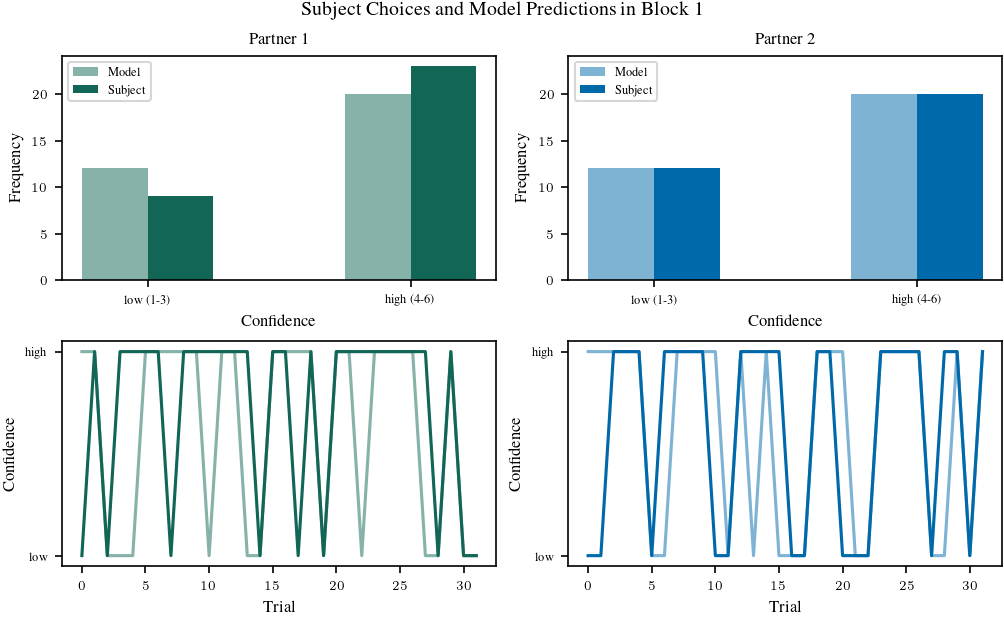

In [122]:
plt.rcParams.update(
    bundles.icml2022(
        column="full",
        nrows=2,
        ncols=2,
        usetex=True,
    )
)
plt.rcParams.update(figsizes.icml2022_full(nrows=2, ncols=2))

for i in range(model_outputs.shape[1]):

    model_choice_p1 = np.argmax(model_outputs_partner1[:, i, :], axis=-1)
    model_counts_p1 = (np.sum(model_choice_p1 == 0), np.sum(model_choice_p1 == 1))
    model_choice_p2 = np.argmax(model_outputs_partner2[:, i, :], axis=-1)
    model_counts_p2 = (np.sum(model_choice_p2 == 0), np.sum(model_choice_p2 == 1))
    model_choice = np.argmax(model_outputs[:, i, :], axis=-1)
    model_counts = (np.sum(model_choice == 0), np.sum(model_choice == 1))
    
    subject_choice_p1 = actual_choices_partner1[:, i]
    subject_counts_p1 = (np.sum(subject_choice_p1 == 0), np.sum(subject_choice_p1 == 1))
    subject_choice_p2 = actual_choices_partner2[:, i]
    subject_counts_p2 = (np.sum(subject_choice_p2 == 0), np.sum(subject_choice_p2 == 1))
    subject_choice = actual_choices[:, i]
    subject_counts = (np.sum(subject_choice == 0), np.sum(subject_choice == 1))
    
    # Plot the distribution of choices for each subject
    labels = ("low (1-3)", "high (4-6)")
    all_choices_p1 = {'Model': model_counts_p1, 'Subject': subject_counts_p1}
    all_choices_p2 = {'Model': model_counts_p2, 'Subject': subject_counts_p2}
    
    x = np.arange(len(labels))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0
    
    fig = plt.figure()
    fig.suptitle('Subject Choices and Model Predictions in Block {subject}'.format(subject=i+1))
    
    ax1 = plt.subplot(221)

    for identity, count in all_choices_p1.items():
        offset = width * multiplier
        if identity == 'Model':
            alpha = 0.5 
        else:
            alpha = 1   
        rects = ax1.bar(x + offset, count, width, color=rgb.mps_green, alpha=alpha, label=identity)
        multiplier += 1

    ax1.set_ylabel('Frequency')
    ax1.set_xlabel('Confidence')
    ax1.set_title('Partner 1')
    ax1.set_xticks(x + width/2, labels)
    ax1.legend()
    
    ax2 = plt.subplot(222, sharey=ax1)
    
    multiplier = 0
    for identity, count in all_choices_p2.items():
        offset = width * multiplier
        if identity == 'Model':
            alpha = 0.5 
        else:
            alpha = 1   
        rects = ax2.bar(x + offset, count, width, color=rgb.tue_blue, alpha=alpha, label=identity)
        multiplier += 1

    ax2.set_ylabel('Frequency')
    ax2.set_xlabel('Confidence')
    ax2.set_title('Partner 2')
    ax2.set_xticks(x + width/2, labels)
    ax2.legend()


    # Plot the choices across all trials
    ax3 = plt.subplot(223)
    ax3.plot(model_choice_p1, color=rgb.mps_green, alpha=0.5, label='Model Partner 1')
    ax3.plot(subject_choice_p1, color=rgb.mps_green, label='Subject Partner 1')
    ax3.set_xlabel('Trial')
    ax3.set_ylabel('Confidence')
    ax3.set_yticks([0,1], labels=['low', 'high'])


    ax4 = plt.subplot(224)
    ax4.plot(model_choice_p2, color=rgb.tue_blue, alpha=0.5, label='Model Partner 2')
    ax4.plot(subject_choice_p2, color=rgb.tue_blue, label='Subject Partner 2')
    ax4.set_xlabel('Trial')
    ax4.set_ylabel('Confidence')
    ax4.set_yticks([0,1], labels=['low', 'high'])
    
    plt.show()